<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **SpaceX  Falcon 9 first stage Landing Prediction**


# Lab 1: Collecting the data


Estimated time needed: **45** minutes


In this capstone, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, you will collect and make sure the data is in the correct format from an API. The following is an example of a successful and launch.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/crash.gif)


Most unsuccessful landings are planned. Space X performs a controlled landing in the oceans. 


## Objectives


In this lab, you will make a get request to the SpaceX API. You will also do some basic data wrangling and formating. 

- Request to the SpaceX API
- Clean the requested data


----


## Import Libraries and Define Auxiliary Functions


We will import the following libraries into the lab


In [1]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the <code>rocket</code> column we would like to learn the booster name.


In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [3]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.


In [4]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.


In [5]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:


In [6]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [7]:
response = requests.get(spacex_url)

Check the content of the response


In [8]:
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

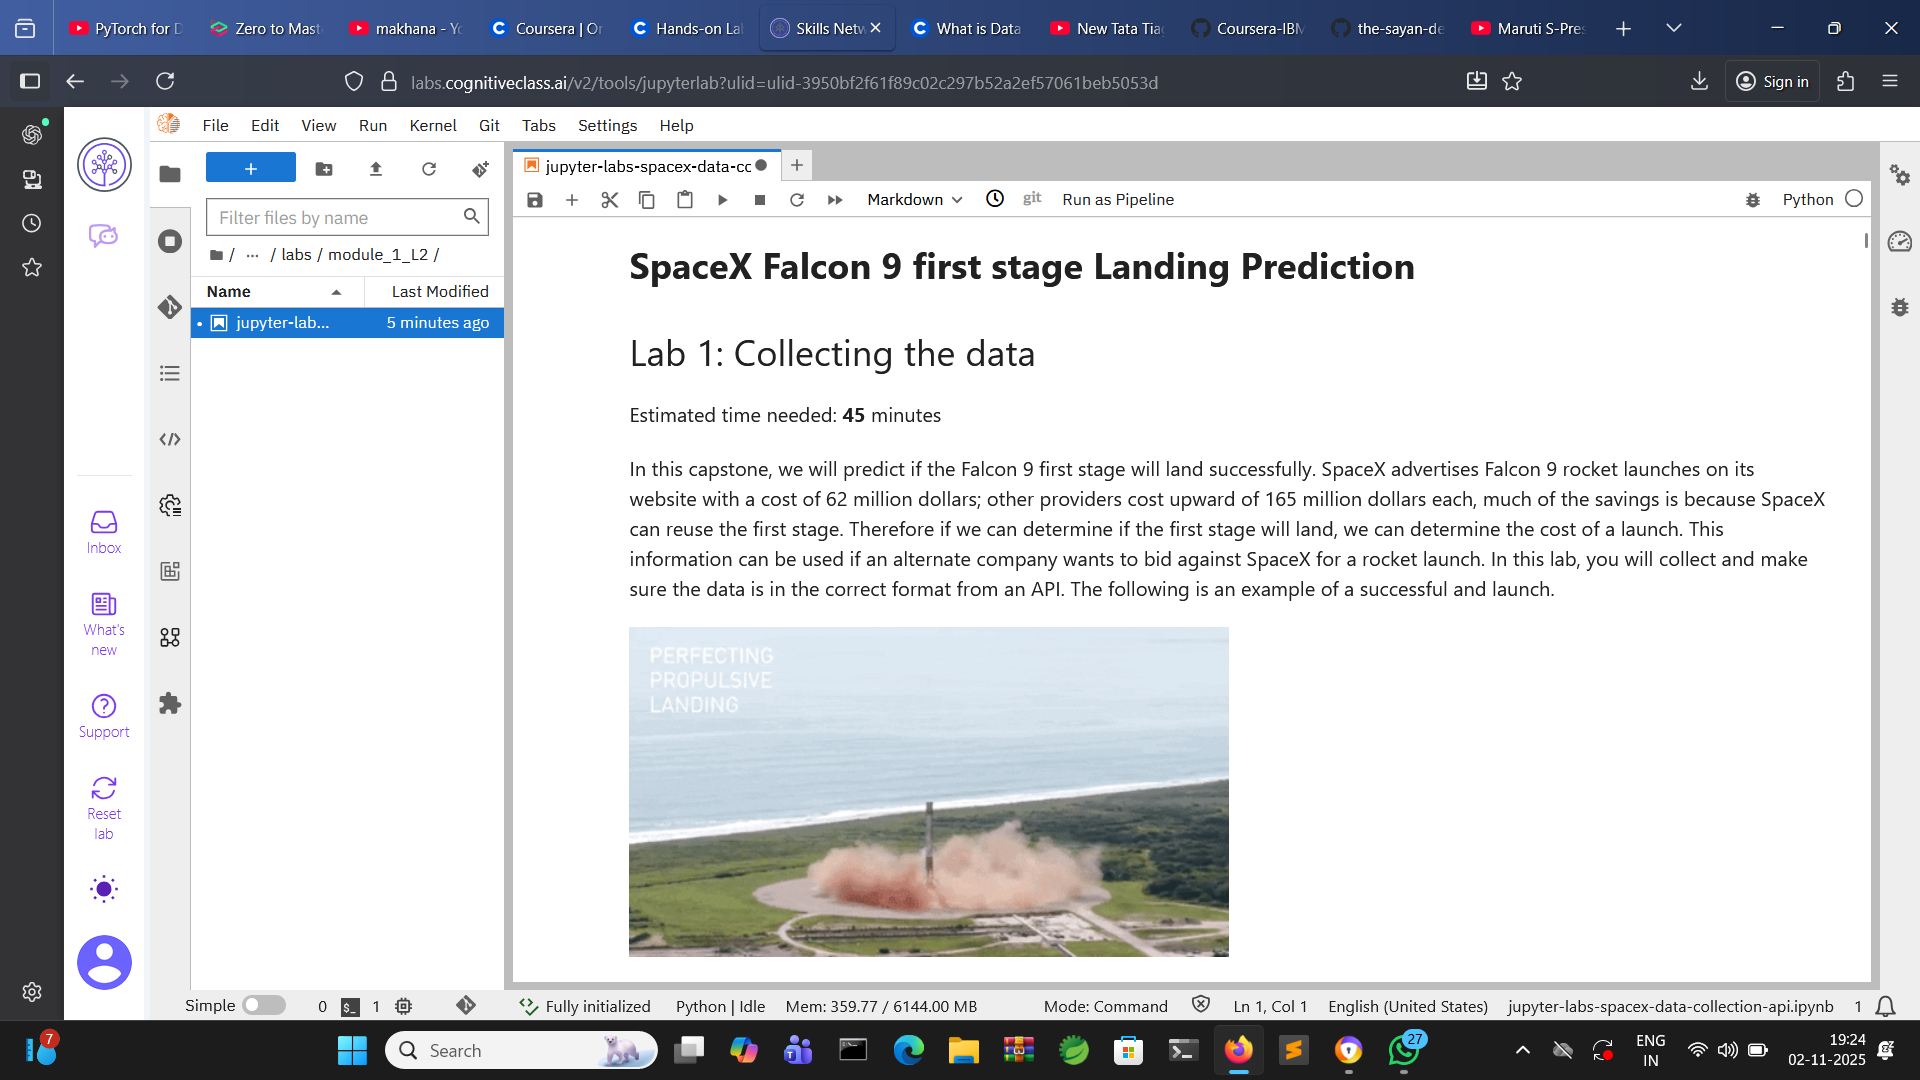You should see the response contains massive information about SpaceX launches. Next, let's try to discover some more relevant information for this project.


### Task 1: Request and parse the SpaceX launch data using the GET request


To make the requested JSON results more consistent, we will use the following static response object for this project:


In [12]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

We should see that the request was successfull with the 200 status response code


In [13]:
response=requests.get(static_json_url)

In [11]:
response.status_code

200

Now we decode the response content as a Json using <code>.json()</code> and turn it into a Pandas dataframe using <code>.json_normalize()</code>


In [14]:
# Use json_normalize meethod to convert the json result into a dataframe
import requests

static_json_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

response = requests.get(static_json_url)


In [15]:
response.status_code


200

In [16]:
data = response.json()


In [17]:
import pandas as pd
from pandas import json_normalize

data_df = json_normalize(data)


Using the dataframe <code>data</code> print the first 5 rows


In [18]:
# Get the head of the dataframe
data_df.head()


,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,capsules,payloads,launchpad,auto_update,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,True,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,"Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,True,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]",2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,True,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/3d/86/cnu0pan8_o.png,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,True,"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,True,[],4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_succes

You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.


In [20]:
# # Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
# data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# # We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
# data = data[data['cores'].map(len)==1]
# data = data[data['payloads'].map(len)==1]

# # Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
# data['cores'] = data['cores'].map(lambda x : x[0])
# data['payloads'] = data['payloads'].map(lambda x : x[0])

# # We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
# data['date'] = pd.to_datetime(data['date_utc']).dt.date

# # Using the date we will restrict the dates of the launches
# data = data[data['date'] <= datetime.date(2020, 11, 13)]


from pandas import json_normalize
import pandas as pd
from datetime import datetime

# Normalize the JSON into a Pandas DataFrame
data = json_normalize(response.json())

# Now select only the columns you need
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# Remove rows with multiple cores or multiple payloads
data = data[data['cores'].map(len) == 1]
data = data[data['payloads'].map(len) == 1]

# Extract the single element from lists
data['cores'] = data['cores'].map(lambda x: x[0])
data['payloads'] = data['payloads'].map(lambda x: x[0])

# Convert date_utc to datetime format and extract only the date
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Restrict the data to only launches before December 13, 2020
data = data[data['date'] <= datetime(2020, 12, 13).date()]

data.head()


,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* **From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.**

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [21]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

These functions will apply the outputs globally to the above variables. Let's take a looks at <code>BoosterVersion</code> variable. Before we apply  <code>getBoosterVersion</code> the list is empty:


In [22]:
BoosterVersion

[]

Now, let's apply <code> getBoosterVersion</code> function method to get the booster version


In [23]:
# Call getBoosterVersion
getBoosterVersion(data)

the list has now been update 


In [24]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

we can apply the rest of the  functions here:


In [25]:
# Call getLaunchSite
getLaunchSite(data)

In [26]:
# Call getPayloadData
getPayloadData(data)

In [27]:
# Call getCoreData
getCoreData(data)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.


In [28]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


Then, we need to create a Pandas data frame from the dictionary launch_dict.


In [29]:
# Create a data from launch_dict
# Create dataframe from launch_dict
launch_df = pd.DataFrame.from_dict(launch_dict)

# Display summary and first few rows
print(launch_df.info())
launch_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    95 non-null     int64  
 1   Date            95 non-null     object 
 2   BoosterVersion  95 non-null     object 
 3   PayloadMass     88 non-null     float64
 4   Orbit           95 non-null     object 
 5   LaunchSite      95 non-null     object 
 6   Outcome         95 non-null     object 
 7   Flights         95 non-null     int64  
 8   GridFins        95 non-null     bool   
 9   Reused          95 non-null     bool   
 10  Legs            95 non-null     bool   
 11  LandingPad      65 non-null     object 
 12  Block           91 non-null     float64
 13  ReusedCount     95 non-null     int64  
 14  Serial          95 non-null     object 
 15  Longitude       95 non-null     float64
 16  Latitude        95 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


Show the summary of the dataframe


In [30]:
# Show the head of the dataframe
launch_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


### Task 2: Filter the dataframe to only include `Falcon 9` launches


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the <code>BoosterVersion</code> column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called <code>data_falcon9</code>.


In [34]:
# Hint data['BoosterVersion']!='Falcon 1'
# Filter only Falcon 9 launches from the main dataset
data_falcon9 = launch_df[launch_df['BoosterVersion'].str.contains('Falcon 9', case=False, na=False)].copy()

# Reset the index after filtering
data_falcon9.reset_index(drop=True, inplace=True)

# Display first few rows
data_falcon9.head()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


Now that we have removed some values we should reset the FlgihtNumber column


In [35]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
87,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
88,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857
89,90,2020-11-05,Falcon 9,3681.0,MEO,CCSFS SLC 40,True ASDS,1,True,False,True,5e9e3032383ecb6bb234e7ca,5.0,8,B1062,-80.577366,28.561857


## Data Wrangling


We can see below that some of the rows are missing values in our dataset.


In [36]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        6
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Before we can continue we must deal with these missing values. The <code>LandingPad</code> column will retain None values to represent when landing pads were not used.


### Task 3: Dealing with Missing Values


Calculate below the mean for the <code>PayloadMass</code> using the <code>.mean()</code>. Then use the mean and the <code>.replace()</code> function to replace `np.nan` values in the data with the mean you calculated.


In [37]:
# Calculate the mean value of PayloadMass column

# Replace the np.nan values with its mean value

import numpy as np

# 1️⃣ Calculate the mean PayloadMass (ignoring NaN values)
mean_payload = data_falcon9['PayloadMass'].mean()

# 2️⃣ Replace NaN values with the mean
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, mean_payload)

# 3️⃣ Confirm missing values are handled
print(data_falcon9['PayloadMass'].isnull().sum())

# 4️⃣ Check if any missing values remain
data_falcon9.info()


0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    91 non-null     int64  
 1   Date            91 non-null     object 
 2   BoosterVersion  91 non-null     object 
 3   PayloadMass     91 non-null     float64
 4   Orbit           91 non-null     object 
 5   LaunchSite      91 non-null     object 
 6   Outcome         91 non-null     object 
 7   Flights         91 non-null     int64  
 8   GridFins        91 non-null     bool   
 9   Reused          91 non-null     bool   
 10  Legs            91 non-null     bool   
 11  LandingPad      65 non-null     object 
 12  Block           91 non-null     float64
 13  ReusedCount     91 non-null     int64  
 14  Serial          91 non-null     object 
 15  Longitude       91 non-null     float64
 16  Latitude        91 non-null     float64
dtypes: bool(3), float64(4), int64(3), o

You should see the number of missing values of the <code>PayLoadMass</code> change to zero.


In [38]:
import pandas as pd

# --- Get the wrangled dataframe ---
try:
    df = data_falcon9.copy()   # from earlier cells in the lab
except NameError:
    df = pd.read_csv("dataset_part_2.csv")  # from Lab 3 export

# Make sure Outcome is string
df["Outcome"] = df["Outcome"].astype(str)

# Q1: How many launches came from CCAFS SLC 40?
q1 = (df["LaunchSite"] == "CCAFS SLC 40").sum()

# Q2: Success rate (first-stage landing success)
# (True *anything* counts as success: True ASDS, True RTLS, True Ocean)
success = df["Outcome"].str.startswith("True").sum()
total   = len(df)
q2_pct  = round(100 * success / total)

# Q3: How many launches went to geosynchronous orbit (GTO)?
q3 = (df["Orbit"] == "GTO").sum()

# Q4: How many mission outcomes were successfully landed to a drone ship?
# (Exactly the label used in the lab)
q4 = (df["Outcome"] == "True ASDS").sum()

print(f"Q1 – CCAFS SLC 40 count: {q1}")
print(f"Q2 – Success rate: {q2_pct}%")
print(f"Q3 – GTO launches: {q3}")
print(f"Q4 – Successful drone-ship landings (True ASDS): {q4}")

# (Optional sanity checks)
# print(df['LaunchSite'].value_counts())
# print(df['Outcome'].value_counts())
# print(df['Orbit'].value_counts())


Q1 – CCAFS SLC 40 count: 0
Q2 – Success rate: 67%
Q3 – GTO launches: 27
Q4 – Successful drone-ship landings (True ASDS): 42


Now we should have no missing values in our dataset except for in <code>LandingPad</code>.


We can now export it to a <b>CSV</b> for the next section,but to make the answers consistent, in the next lab we will provide data in a pre-selected date range. 


<code>data_falcon9.to_csv('dataset_part_1.csv', index=False)</code>


## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


<!--## Change Log
-->


<!--

|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2020-09-20|1.1|Joseph|get result each time you run|
|2020-09-20|1.1|Azim |Created Part 1 Lab using SpaceX API|
|2020-09-20|1.0|Joseph |Modified Multiple Areas|
-->


Copyright ©IBM Corporation. All rights reserved.
